In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
%matplotlib inline

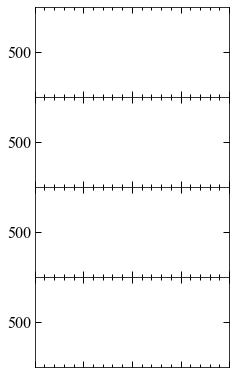

In [41]:
fig = plt.figure(figsize=(10, 5))

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))
ax3 = fig.add_axes([0.1, 1-3*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))
ax4 = fig.add_axes([0.1, 1-4*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))


# set the yticks for each subplot
ax1.set_yticks([500])
ax2.set_yticks([500])
ax3.set_yticks([500])
ax4.set_yticks([500])

plt.show()

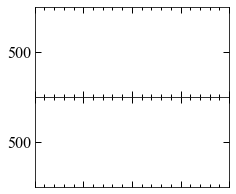

In [42]:
fig = plt.figure(figsize=(10, 5))

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 1e3))



# set the yticks for each subplot
ax1.set_yticks([500])
ax2.set_yticks([500])


plt.show()

# GRB181222B

In [111]:
tlagg_asim = -0.44

df_asim = harvest_data(fn='2018_12_22_20_11_36',T0='2018-12-22T20:11:36.576')
df_asim['tus']+=tlagg_asim
tus_asim = df_asim['tus'].to_numpy()
#bin tus_asim by the bins specified by KW

dau/det starting from index 1
tus array given in seconds
safety time:  0.507 % removed
sorted by tus (s)


,datetime,tus,adr,dau,det,erg,keV,st,dt,flag
0,2018-12-22 20:08:40.938758722,-176.077241,1,1,1,85,830.2813,2.321125,0.000,False
1,2018-12-22 20:08:40.938839972,-176.077160,1,1,1,78,763.0874,2.052350,81.250,False
2,2018-12-22 20:08:40.938840639,-176.077159,9,3,3,57,1254.9009,1.169934,552.445,False
3,2018-12-22 20:08:40.939426472,-176.076574,12,4,3,91,1097.8659,2.326220,0.000,False
4,2018-12-22 20:08:40.939426528,-176.076573,2,1,2,28,518.0864,1.036173,586.528,False


In [43]:
#importing KW LC

kw_fn = 'GRB181222B_2ms.txt'
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32),kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_df.head()

,Ti,Tf,G1,G2,G3
0,-0.512,-0.510,0.00,1.00,0.0
1,-0.510,-0.508,5.04,1.00,0.0
2,-0.508,-0.506,1.00,0.00,0.0
3,-0.506,-0.504,0.00,0.00,1.0
4,-0.504,-0.502,1.00,2.01,0.0


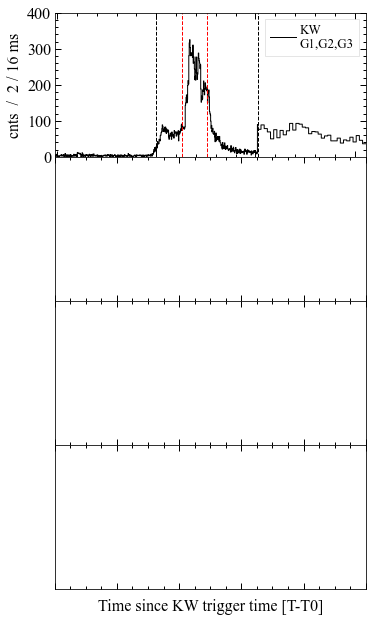

In [112]:
fig = plt.figure(figsize=(16, 8))

binsize=0.002
intervals = [[0.0,0.512],[0.128,0.256]]

ax_height = 1/4

ax1 = fig.add_axes([0.1, 1-ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 400))
ax2 = fig.add_axes([0.1, 1-2*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 200))
ax3 = fig.add_axes([0.1, 1-3*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 500))
ax4 = fig.add_axes([0.1, 1-4*ax_height, 0.27, ax_height], xticklabels=[], ylim=(0, 500))


# set the yticks for each subplot

ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

kw_dt = np.round(np.diff(kw_bin_lo),3)
jx_kw = np.where(kw_dt>binsize)[0][0]+35 #finding first entry where the binsize increases
kw_counts_1 = G1[:jx_kw]+G2[:jx_kw]+G3[:jx_kw]
#kw_counts_2 = G1[jx_kw:jx_kw+100]+G1[jx_kw:jx_kw+100]+G1[jx_kw:jx_kw+100]/8
ax1.step(x=kw_bin_lo[:jx_kw],y=kw_counts_1,where='pre',label='KW\nG1,G2,G3',color='black')
#ax1.step(x=kw_bin_lo[jx_kw:jx_kw+100],y=kw_counts,where='pre',label='KW',color='black')
ax1.set_yticks([0,100,200,300,400])
ax1.set_ylabel(f'cnts  /  {round(binsize*1e3)} / 16 ms')
ax1.vlines(x=intervals[0][0],ymin=0,ymax=400,color='black',linestyle='--')
ax1.vlines(x=intervals[0][1],ymin=0,ymax=400,color='black',linestyle='--')
ax1.vlines(x=intervals[1][0],ymin=0,ymax=400,color='red',linestyle='--')
ax1.vlines(x=intervals[1][1],ymin=0,ymax=400,color='red',linestyle='--')
ax1.legend()
plt.xlabel('Time since KW trigger time [T-T0]')
plt.show()